# 0 - Imports

In [36]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Concatenate, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score


# 1 - Preprocessing

Let's visualize our data

In [37]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load the dataset
data = pd.read_json('train.json', lines=True, nrows=20000)
data.head(5)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}"
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answer_start': [188]}"
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"{'text': ['the Main Building'], 'answer_start': [279]}"
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"{'text': ['a Marian place of prayer and reflection'], 'answer_start': [381]}"
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of pra

Let's see how many rows does this dataset have

In [38]:
data.shape

(20000, 5)

Our architecture should be as follows: 
1. preprocessing (ez, we will use a pre-trained model)
    -  text input loksha wa7da?
2. neural network architecture (we will use RNN)
    - use RNN, or LSTM (which type?)
    - attention mechanism?
3. traning and evaluation 
    - how to evaluate/validate? 

In [39]:
# Check for missing values
data.isnull().sum()

id          0
title       0
context     0
question    0
answers     0
dtype: int64

# 2 - Model Attempt with Basic BiLSTM

In [40]:
# calculat the end index of each answer
def get_end_index(data):

    answer_starts = data['answers'].apply(lambda x: x['answer_start'][0])
    answer_texts = data['answers'].apply(lambda x: x['text'][0])
    answer_ends = answer_starts + answer_texts.str.len()

    # create a list of dicts containing the answer and start and end indices
    answer_info = []
    for i in range(len(data)):
        answer_info.append({
            'text': data['answers'][i]['text'][0],
            'answer_start': answer_starts[i],
            'answer_end': answer_ends[i]
        })

    # replace the 'answers' column with the new list of dicts
    data['answers'] = answer_info

    return data

In [41]:
# Add the end index to the data
data = get_end_index(data)
# Check the data again
data.head(5)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"{'text': 'Saint Bernadette Soubirous', 'answer_start': 515, 'answer_end': 541}"
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"{'text': 'a copper statue of Christ', 'answer_start': 188, 'answer_end': 213}"
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"{'text': 'the Main Building', 'answer_start': 279, 'answer_end': 296}"
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"{'text': 'a Marian place of prayer and reflection', 'answer_start': 381, 'answer_end': 420}"
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediat

In [42]:
# re-calculate the start and end indices in terms of words 
def get_word_indices(data):
    for i in range(len(data)):
        text = data['context'][i]
        answer_start = data['answers'][i]['answer_start']
        answer_end = data['answers'][i]['answer_end']
        new_start_idx = text[:answer_start].count(' ') + 1
        new_end_idx = text[:answer_end].count(' ') + 1 
        data['answers'][i]['answer_start'] = new_start_idx
        data['answers'][i]['answer_end'] = new_end_idx
    return data


In [43]:
# Add the word indices to the data
data = get_word_indices(data)
# Check the data again
data.head(5)

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"{'text': 'Saint Bernadette Soubirous', 'answer_start': 91, 'answer_end': 93}"
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"{'text': 'a copper statue of Christ', 'answer_start': 33, 'answer_end': 37}"
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"{'text': 'the Main Building', 'answer_start': 50, 'answer_end': 52}"
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"{'text': 'a Marian place of prayer and reflection', 'answer_start': 67, 'answer_end': 73}"
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behi

Let's prepare the data the way we need to 

In [ ]:
# Params 
max_len_context = 1024
max_len_question = 64
embedding_dim = 300  

lstm_units = 128
lstm_units2 = 64

batch_size = 64
epochs = 30
validation_split = 0.2

In [45]:
contexts = data['context'].tolist()
questions = data['question'].tolist()
# answers = data['answers'].tolist()
# answer_texts = [answer['text'] for answer in answers]

In [46]:
# Initialized the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(contexts + questions)

In [47]:


# Convert the texts to sequences
contexts_seq = tokenizer.texts_to_sequences(contexts)
questions_seq = tokenizer.texts_to_sequences(questions)
# answer_seq = tokenizer.texts_to_sequences(answer_texts)

# Pad the sequences to the same length
X_contexts = pad_sequences(contexts_seq, maxlen=max_len_context, padding='post')
X_questions = pad_sequences(questions_seq, maxlen=max_len_question, padding='post')
# X_answers = pad_sequences(answer_seq, maxlen=max_len_context, padding='post')


In [48]:
# def convert_char_index_to_token_index(contexts_seq, answers, answers_seq):
    
#     start_idx_chars = answers.map(lambda x: x['answer_start']).tolist()
#     end_idx_chars = answers.map(lambda x: x['answer_end']).tolist()
#     start_idx_tokens = []
#     end_idx_tokens = []
#     char_idx_to_token_idx = []


#     for i in range(contexts_seq.shape[0]):
#         temp_map = {}
#         char_start_idx = start_idx_chars[i]
#         char_end_idx = end_idx_chars[i]
#         context = contexts_seq[i]
#         answer = answers_seq[i]
#         answer_non_zero = answer[answer != 0] # Remove the padding from the answer sequence
#         context_str = ' '.join([str(x) for x in context])
#         # answer_str = ' '.join([str(x) for x in answer if x != 0])
#         start_idx = context_str.find(str(answer[0])) # Find the start index of the answer in the context string
#         if start_idx != 0 and start_idx != -1:
#             start_idx = context_str[:start_idx].count(' ') + 1  # Find the start index of the answer in the context string
#         end_idx = start_idx + len(answer_non_zero) - 1 # Find the end index of the answer in the context string
#         start_idx_tokens.append(start_idx)
#         end_idx_tokens.append(end_idx)
#         temp_map[char_start_idx] = start_idx
#         temp_map[char_end_idx] = end_idx
#         char_idx_to_token_idx.append(temp_map)


#     return start_idx_tokens, end_idx_tokens, char_idx_to_token_idx

# token_starts, token_ends, char_idx_to_token_idx = convert_char_index_to_token_index(X_contexts, data['answers'], X_answers)

# # Convert the token indices to numpy arrays
# y_start = np.array(token_starts)
# y_end = np.array(token_ends)

we will one-hot encode the start and end indices to simplify calculations

In [49]:
def to_one_hot(positions, seq_length):
    one_hot = np.zeros((len(positions), seq_length))
    for i, pos in enumerate(positions):
        one_hot[i, pos] = 1
    return one_hot

In [50]:
y_start = data['answers'].map(lambda x: x['answer_start']).tolist()
y_end = data['answers'].map(lambda x: x['answer_end']).tolist()

# Convert the start and end positions to one-hot encoding
start_positions = to_one_hot(y_start, max_len_context)
end_positions = to_one_hot(y_end, max_len_context)

Now, it's time to create the embeddings layer, in our case we will be using Word2Vec

In [51]:
w2v_path = 'C:/Users/shame/Downloads/GoogleNews-vectors-negative300.bin'
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [52]:
word_index = tokenizer.word_index  # word -> int mapping
vocab_size = len(word_index) + 1   # +1 because Keras tokenizer indices start at 1 

In [53]:
# If the word is not in the Word2Vec vocabulary, it remains a zero vector.
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.key_to_index:
        embedding_matrix[i] = w2v_model[word]

embedding_matrix = np.array(embedding_matrix, dtype=np.float32)
    

Now, it's time to define the layers of our model

In [54]:
# Embedding layer
# Create the embedding layer using the pre-trained weights
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,  # Typically set to False to keep pre-trained embeddings fixed
    mask_zero=False     # Optionally True if you want the model to skip padding positions
)

# Input layers
context_input = Input(shape=(max_len_context,), name='context_input')
question_input = Input(shape=(max_len_question,), name='question_input')

# Embeddings
context_embedded = embedding_layer(context_input)   # (batch, max_len_context, embedding_dim)
question_embedded = embedding_layer(question_input) # (batch, max_len_question, embedding_dim)

# Encode question (simple BiLSTM + pooling)
question_encoded = Bidirectional(LSTM(lstm_units2, return_sequences=True,dropout=0.4))(question_embedded)
question_pooled = GlobalMaxPool1D()(question_encoded)  # shape (batch, 128)

# Encode context (simple BiLSTM)
# We can pass question info into the context encoding by concatenating question_pooled at each timestep
# or by more advanced attention. Here we do a minimal approach: just combine after BiLSTM for demonstration.
context_encoded = Bidirectional(LSTM(lstm_units, return_sequences=True,dropout=0.4))(context_embedded)  # (batch, max_len_context, 256)

# Combine question + context: broadcast question vector to each context timestep
# One approach is to tile question_pooled and concat. For simplicity, let's do a naive approach:
# Expand dims of question_pooled to shape (batch, 1, 128) then tile across time steps using Lambda layers.

question_expanded = tf.keras.layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, tf.float32), axis=1))(question_pooled)  # (batch, 1, 128)
question_tiled = tf.keras.layers.Lambda(lambda x: tf.tile(x, [1, max_len_context, 1]))(question_expanded)  # (batch, max_len_context, 128)

merged = Concatenate(axis=-1)([context_encoded, question_tiled])  # shape (batch, max_len_context, 256+128=384)

# Output heads for start and end
# We want two separate distributions over max_len_context
start_logits = Dense(1, activation=None)(merged)  # shape (batch, max_len_context, 1)
end_logits   = Dense(1, activation=None)(merged)  # shape (batch, max_len_context, 1)

# Squeeze out the last dimension so we have (batch, max_len_context)
start_logits = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(start_logits)  # shape (batch, max_len_context)
end_logits   = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(end_logits)  # shape (batch, max_len_context)

# Softmax over the sequence length to get probability distribution
start_probs = tf.keras.layers.Activation('softmax', name='start_output')(start_logits)
end_probs   = tf.keras.layers.Activation('softmax', name='end_output')(end_logits)

# Define the model
model = Model(
    inputs=[context_input, question_input],
    outputs=[start_probs, end_probs]
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 context_input (InputLayer)     [(None, 1024)]       0           []                               
                                                                                                  
 question_input (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        multiple             10268400    ['context_input[0][0]',          
                                                                  'question_input[0][0]']         
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 64, 256)     439296      ['embedding_2[1][0]']      

And now let's compile and train our model

In [55]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [56]:
print(X_contexts.shape, X_questions.shape)
print(start_positions.shape, end_positions.shape)

(20000, 1024) (20000, 64)
(20000, 1024) (20000, 1024)


In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    loss={
        'start_output': 'categorical_crossentropy',
        'end_output': 'categorical_crossentropy'
    },
    metrics={'start_output': 'accuracy', 'end_output': 'accuracy'}
)

# Ensure that input tensors are of type float32
X_contexts = np.array(X_contexts, dtype=np.float32)
X_questions = np.array(X_questions, dtype=np.float32)
start_positions = np.array(start_positions, dtype=np.int32)  # if using categorical
end_positions = np.array(end_positions, dtype=np.int32)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
# earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
history = model.fit(
    x=[X_contexts, X_questions],
    y=[start_positions, end_positions],
    batch_size=batch_size,
    shuffle=True,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[reduce_lr]
)

Epoch 1/30


InternalError: Graph execution error:

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 300, 256, 1, 1024, 64, 256] 
	 [[{{node CudnnRNN}}]]
	 [[model_2/bidirectional_5/backward_lstm_5/PartitionedCall]] [Op:__inference_train_function_63793]

In [ ]:
model.save('qa_model_v8.h5')

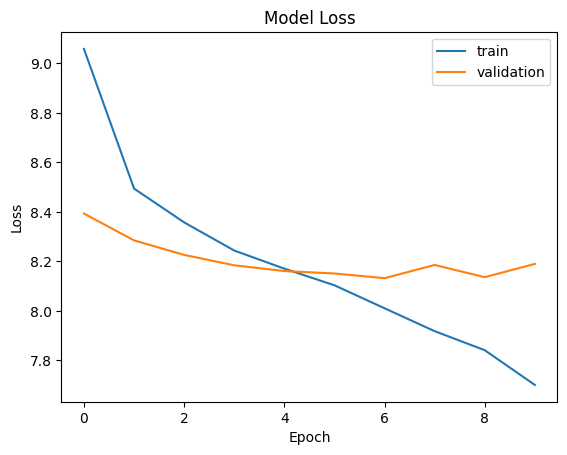

In [28]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

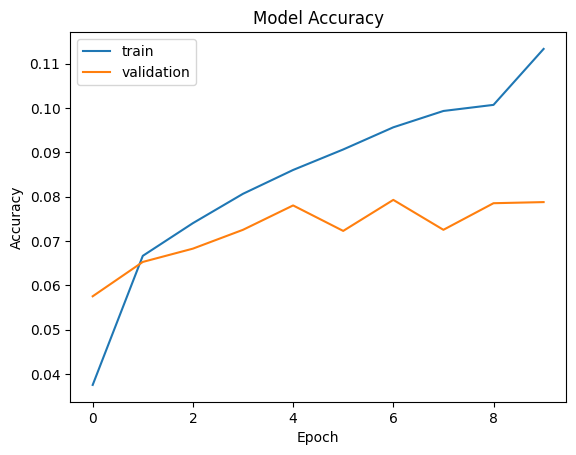

In [29]:
# plot accuracy
plt.plot(history.history['start_output_accuracy'], label='train')
plt.plot(history.history['val_start_output_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Now, let's try some examples

In [ ]:
# # Suppose we have new context/question
# test_context_seq = pad_sequences(
#     tokenizer.texts_to_sequences(["Machine learning is a field of AI that focuses on the development of algorithms that allow computers to learn from and make predictions based on data."]),
#     maxlen=max_len_context, padding='post'
# )

# test_question_seq = pad_sequences(
#     tokenizer.texts_to_sequences(["What is machine learning?"]),
#     maxlen=max_len_question, padding='post'
# )

# pred_start, pred_end = model.predict([test_context_seq, test_question_seq])

# # pred_start and pred_end are probability distributions over positions [0..max_len_context-1]
# start_idx = np.argmax(pred_start[0])  
# end_idx   = np.argmax(pred_end[0])

# print("Predicted start index:", start_idx)
# print("Predicted end index:  ", end_idx)

# # If you want the actual tokens:
# tokens_context = tokenizer.sequences_to_texts(test_context_seq)[0].split()
# predicted_answer_tokens = tokens_context[start_idx:end_idx+1]
# predicted_answer = " ".join(predicted_answer_tokens)

# print("Question:", "What is machine learning?")
# print("Predicted answer tokens:", predicted_answer_tokens)
# print("Predicted answer:", predicted_answer)

Now let's calculate some actual metrics

In [30]:
validation = pd.read_json('validation.json', lines=True, nrows=1000)

In [31]:
validation.shape

(1000, 5)

In [32]:
get_end_index(validation)
validation = get_word_indices(validation)
validation.head(5)

,id,title,context,question,answers
0,56be4db0acb8001400a502ec,Super_Bowl_50,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.",Which NFL team represented the AFC at Super Bowl 50?,"{'text': 'Denver Broncos', 'answer_start': 29, 'answer_end': 30}"
1,56be4db0acb8001400a502ed,Super_Bowl_50,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.",Which NFL team represented the NFC at Super Bowl 50?,"{'text': 'Carolina Panthers', 'answer_start': 38, 'answer_end': 39}"
2,56be4db0acb8001400a502ee,Super_Bowl_50,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.",Where did Super Bowl 50 take place?,"{'text': 'Santa Clara, California', 'answer_start': 66, 'answer_end': 68}"
3,56be4db0acb8001400a502ef,Super_Bowl_50,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.",Which NFL team won Super Bowl 50?,"{'text': 'Denver Broncos', 'answer_start': 29, 'answer_end': 30}"
4,56be4db0acb8001400a502f0,Super_Bowl_50,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champio

In [ ]:
# load the saved model
saved_model = load_model('qa_model_v8.h5')

# Prepare the validation data
validation_contexts = validation['context'].tolist()
validation_questions = validation['question'].tolist()
# validation_answers = validation['answers'].tolist()

validation_contexts_seq = tokenizer.texts_to_sequences(validation_contexts)
validation_questions_seq = tokenizer.texts_to_sequences(validation_questions)
# validation_answers_seq = tokenizer.texts_to_sequences([answer['text'] for answer in validation_answers])

validation_X_contexts = pad_sequences(validation_contexts_seq, maxlen=max_len_context, padding='post')
validation_X_questions = pad_sequences(validation_questions_seq, maxlen=max_len_question, padding='post')
# validation_X_answers = pad_sequences(validation_answers_seq, maxlen=max_len_context, padding='post')

validation_token_starts = validation['answers'].map(lambda x: x['answer_start']).tolist()
validation_token_ends = validation['answers'].map(lambda x: x['answer_end']).tolist()
# validation_token_starts, validation_token_ends, map = convert_char_index_to_token_index(validation_X_contexts, validation['answers'], validation_X_answers)

validation_start_positions = to_one_hot(validation_token_starts, max_len_context)
validation_end_positions = to_one_hot(validation_token_ends, max_len_context)

validation_start_positions = np.array(validation_start_positions, dtype=np.int32)  
validation_end_positions = np.array(validation_end_positions, dtype=np.int32)
validation_X_contexts = np.array(validation_X_contexts, dtype=np.float32)
validation_X_questions = np.array(validation_X_questions, dtype=np.float32)

In [34]:
# Evaluate the model on the validation set
results = saved_model.evaluate(
    [validation_X_contexts, validation_X_questions],
    [validation_start_positions, validation_end_positions],
    batch_size=batch_size
)

# calculate the accuracy of the model on the validation set
start_accuracy = results[3]  # accuracy for start positions
end_accuracy = results[4]    # accuracy for end positions

# show the real sentences from model predictions
pred_start, pred_end = saved_model.predict([validation_X_contexts, validation_X_questions])
pred_start = np.argmax(pred_start, axis=1)
pred_end = np.argmax(pred_end, axis=1)

# actual tokens 
tokens_context = tokenizer.sequences_to_texts(validation_X_contexts.tolist())
questions = tokenizer.sequences_to_texts(validation_X_questions.tolist())
predicted_answers = []
for i in range(len(pred_start)):
    start_idx = pred_start[i]
    end_idx = pred_end[i]
    predicted_answer_tokens = tokens_context[i].split()[start_idx:end_idx+1]
    predicted_answers.append(" ".join(predicted_answer_tokens))
    print("Question:", questions[i])
    print("Predicted start index:", start_idx)
    print("Predicted end index:  ", end_idx)
    print("Actual answer start:", validation['answers'][i]['answer_start'])
    print("Actual answer end:", validation['answers'][i]['answer_end'])
    print("Predicted answer:", predicted_answers[i])
    print("Actual answer:", validation['answers'][i]['text'])
    print("===========================================================")


32/32 [==============================] - 5s 106ms/step
Question: which nfl team represented the at super bowl 50
Predicted start index: 1
Predicted end index:   28
Actual answer start: 29
Actual answer end: 30
Predicted answer: bowl 50 was an american football game to determine the champion of the national football league nfl for the 2015 season the american football conference champion denver defeated
Actual answer: Denver Broncos
Question: which nfl team represented the at super bowl 50
Predicted start index: 1
Predicted end index:   28
Actual answer start: 38
Actual answer end: 39
Predicted answer: bowl 50 was an american football game to determine the champion of the national football league nfl for the 2015 season the american football conference champion denver defeated
Actual answer: Carolina Panthers
Question: where did super bowl 50 take place
Predicted start index: 1
Predicted end index:   28
Actual answer start: 66
Actual answer end: 68
Predicted answer: bowl 50 was an ameri

In [35]:
# Flatten the start and end positions
start_positions_flat = np.argmax(validation_start_positions, axis=1)
end_positions_flat = np.argmax(validation_end_positions, axis=1)
pred_start_flat = pred_start.flatten()
pred_end_flat = pred_end.flatten()

print(f"Start Position Accuracy: {start_accuracy:.4f}")
print(f"End Position Accuracy: {end_accuracy:.4f}")

# Calculate the F1 score
f1 = f1_score(start_positions_flat, pred_start_flat, average='weighted')
print(f"F1 start index Score: {f1:.4f}")

f1 = f1_score(end_positions_flat, pred_end_flat, average='weighted')
print(f"F1 end index Score: {f1:.4f}")

Start Position Accuracy: 0.0300
End Position Accuracy: 0.0320
F1 start index Score: 0.0188
F1 end index Score: 0.0248
